In [352]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import time

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (15,7)})

from warnings import filterwarnings
filterwarnings('ignore')

In [353]:
train_df = pd.read_csv("dataset/rolling_mean_imputation.csv")

In [354]:
train_df.head()

,Unnamed: 0,All_date,Close
0,0,2000-08-30,4.805000
1,1,2000-08-31,4.780000
2,2,2000-09-01,4.835000
3,3,2000-09-02,4.806667
4,4,2000-09-03,4.807222


In [355]:
train_df = train_df.drop(['Unnamed: 0'], axis=1)
train_df.rename(columns={'All_date':'Date'}, inplace=True)

In [356]:
train_df.tail()

,Date,Close
7424,2020-12-27,2.580148
7425,2020-12-28,2.305000
7426,2020-12-29,2.467000
7427,2020-12-30,2.422000
7428,2020-12-31,2.539000


In [357]:
train_df.Date = pd.to_datetime(train_df.Date, infer_datetime_format=True)

In [358]:
val_df = pd.read_csv("dataset/ngp_val.csv")[["Date", "Close"]]
test_df= pd.read_csv("dataset/ngp_test.csv")[["Date", "Close"]]

In [359]:
df = pd.concat([train_df, val_df, test_df], axis=0)

In [360]:
df = df.reset_index(drop=True)

In [361]:
df.shape

(7847, 2)

In [362]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7847 entries, 0 to 7846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    7847 non-null   object 
 1   Close   7847 non-null   float64
dtypes: float64(1), object(1)
memory usage: 122.7+ KB


In [363]:
df.head()

,Date,Close
0,2000-08-30 00:00:00,4.805000
1,2000-08-31 00:00:00,4.780000
2,2000-09-01 00:00:00,4.835000
3,2000-09-02 00:00:00,4.806667
4,2000-09-03 00:00:00,4.807222


In [364]:
df.tail()

,Date,Close
7842,2022-08-19,9.336
7843,2022-08-22,9.680
7844,2022-08-23,9.193
7845,2022-08-24,9.330
7846,2022-08-25,9.347


In [186]:
train_end = df.loc[df['Date']=="2020-12-31"].index[0]

In [187]:
train_end

7428

In [188]:
df.tail()

,Date,Close
7842,2022-08-19,9.336
7843,2022-08-22,9.680
7844,2022-08-23,9.193
7845,2022-08-24,9.330
7846,2022-08-25,9.347


In [189]:
train_data = df.loc[:train_end,"Close"].values

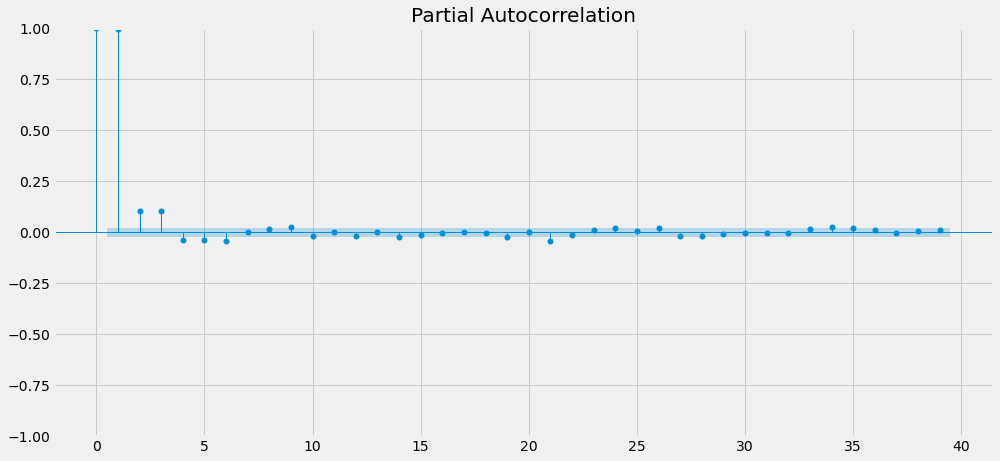

In [190]:
mpl.rcParams['lines.linewidth'] = 1
plt.rcParams.update({'figure.figsize': (15,7)})
plot_pacf(train_data, method="ywm");print()

In [191]:
train_data = train_data.reshape((-1,1))

In [192]:
train_data.shape

(7429, 1)

In [193]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(DEVICE))

Using cuda device


In [194]:
timestamps = 21
BATCH_SIZE=64

In [195]:
X = []
y = []

for i in range(timestamps, len(df)):
    X.append(df.loc[i-timestamps:i-1, "Close"])
    y.append((df.loc[i, "Close"], df.loc[i, "Date"]))

In [196]:
X,y = np.array(X), np.array(y)

In [197]:
X.shape, y.shape

((7826, 21), (7826, 2))

In [198]:
train_idx = 0
for i in range(y.shape[0]):
    if y[i][1]=="2020-12-31":
        train_idx=i
        break

In [199]:
train_idx

7407

In [202]:
val_test_dates = y[train_idx+2:, 1]

In [203]:
y = y[:,0].astype(np.float32)

In [204]:
y.shape

(7826,)

In [116]:
X_train, y_train = X[:train_idx+1], y[:train_idx+1]

In [117]:
test_val_len = (len(X)-train_idx)//2

In [118]:
X_val, y_val = X[train_idx+1:train_idx+1+test_val_len], y[train_idx+1:train_idx+1+test_val_len]
X_test, y_test = X[train_idx+1+test_val_len:], y[train_idx+1+test_val_len:]

In [119]:
scaler = StandardScaler()

In [120]:
X_train.shape

(7408, 21)

In [121]:
X_val.shape

(209, 21)

In [122]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [123]:
class CustomDataset:
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        '''returns a dictionary of tensors'''
        current_sample = self.data[idx, :]
        current_target = self.targets[idx]
        
        X = torch.tensor(current_sample, dtype=torch.float32)
        X = torch.reshape(X, (1, -1))
        y = torch.tensor(current_target, dtype = torch.float32)
        
        return {
            "X":X,
            "y":y
        }

In [124]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

In [125]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [126]:
train_loader.dataset[0]

{'X': tensor([[0.1102, 0.0994, 0.1236, 0.1113, 0.1117, 0.1158, 0.1789, 0.2250, 0.1958,
          0.1442, 0.1886, 0.1765, 0.2037, 0.1995, 0.2215, 0.2830, 0.2875, 0.2643,
          0.2786, 0.3274, 0.3604]]),
 'y': tensor(5.3200)}

In [127]:
for batch_idx, data in enumerate(train_loader):
    print(data['X'].shape)
    break

torch.Size([64, 1, 21])


In [128]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_layers = lstm_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=lstm_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        
        h0 = torch.zeros((self.lstm_layers, x.shape[0], self.hidden_size), device=DEVICE).requires_grad_()
        c0 = torch.zeros((self.lstm_layers, x.shape[0], self.hidden_size), device=DEVICE).requires_grad_()
        
        lstm_out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = self.linear(hn[-1])
        
        #Flattening the result
        out = out.view(-1)
        return out

In [129]:
input_size = timestamps
hidden_size = 273 #from research paper 150; seasonality = 253, 506; best = 273
lstm_layers = 3 #best=3

In [130]:
model = Model(input_size, hidden_size, lstm_layers)

In [131]:
model.to(DEVICE)

Model(
  (lstm): LSTM(21, 273, num_layers=3, batch_first=True)
  (linear): Linear(in_features=273, out_features=1, bias=True)
)

## Checking if the model is processing the input correct or not

In [132]:
dataloader = iter(train_loader)

In [133]:
data = next(dataloader)

In [134]:
out = model(data['X'].to(DEVICE))
out, data['X'].shape

(tensor([0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
         0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
         0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0100, 0.0100, 0.0101, 0.0101,
         0.0101, 0.0101, 0.0101, 0.0102, 0.0102, 0.0102, 0.0101, 0.0101, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0101, 0.0100, 0.0101, 0.0101, 0.0101,
         0.0101, 0.0101, 0.0101, 0.0102, 0.0102, 0.0101, 0.0102, 0.0102, 0.0102,
         0.0102, 0.0102, 0.0102, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101,
         0.0101], device='cuda:0', grad_fn=<ViewBackward0>),
 torch.Size([64, 1, 21]))

In [135]:
out.shape

torch.Size([64])

In [136]:
data['y'], data['y'].shape

(tensor([5.3200, 5.2870, 5.1310, 5.2460, 5.2213, 5.2760, 5.3600, 5.3300, 5.1400,
         5.2000, 5.2233, 5.1878, 5.3520, 5.3480, 5.2900, 5.1520, 5.0000, 5.1473,
         5.0998, 5.1500, 5.1340, 5.5850, 5.6250, 5.5350, 5.5817, 5.5806, 5.3550,
         5.4600, 5.2100, 4.9600, 4.9370, 5.0357, 4.9776, 5.0720, 4.8200, 4.6500,
         4.6550, 4.5300, 4.6117, 4.5989, 4.4800, 4.5000, 4.6860, 4.7600, 4.9100,
         4.7853, 4.8184, 4.8490, 5.0800, 5.3400, 5.4450, 5.4600, 5.4150, 5.4400,
         5.6900, 6.0200, 6.2400, 5.7900, 6.1200, 6.0500, 5.9867, 6.2400, 6.4100,
         6.5770]),
 torch.Size([64]))

In [137]:
#Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Training

In [138]:
def train_one_step(model, data, loss_fn, optimizer):
    optimizer.zero_grad()
    X = data['X'].to(DEVICE)
    y = data['y'].to(DEVICE)
    
    preds = model(X)
    loss = loss_fn(preds, y)
    
    r2 = r2_score(y.detach().cpu().numpy(), preds.detach().cpu().numpy().flatten())
    
    loss.backward()
    optimizer.step()
    
    return loss,r2

In [139]:
def train(model, data_loader, loss_fn, optimizer, scheduler=None):
    model.train()
    total_loss = 0
    total_score = 0
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    
    for batch_idx, data in enumerate(data_loader):
        loss, batch_score = train_one_step(model, data, loss_fn, optimizer)
        
        if scheduler is not None:
            scheduler.step(loss)
            
        total_loss += loss.item()
        total_score += batch_score
        
        if batch_idx%8 == 0:
            batch_loss, current = loss.item(), batch_idx*len(X)
            
            print(f"loss: {batch_loss}, R2 Score: {batch_score}  {current}/{size}")
            
    train_score = total_score/num_batches
    train_loss = total_loss/num_batches
    print(f"Train loss: {train_loss}, R2 Score: {train_score}")
        
    return {'train_score': train_score, 'train_loss':train_loss}

In [140]:
def eval_one_step(model, data, loss_fn):
    X = data['X'].to(DEVICE)
    y = data['y'].to(DEVICE)
    
    preds = model(X)
    loss = loss_fn(preds, y)
    
    r2 = r2_score(y.detach().cpu().numpy(), preds.detach().cpu().numpy().flatten())
    
    return loss, r2

In [141]:
def evaluate(model, data_loader, loss_fn):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    
    model.eval()
    
    total_loss, total_score =0,0
    
    with torch.no_grad():
        for batch_idx, data in enumerate(data_loader):
            loss, score = eval_one_step(model, data, loss_fn)
            total_loss +=loss.item()
            total_score +=score
        
    test_score = total_score/num_batches
    test_loss = total_loss/num_batches
    print(f"Val loss: {test_loss}, R2 Score: {test_score}")
        
    return {'score': test_score, 'loss':test_loss}

In [142]:
EPOCHS=300

In [143]:
from collections import defaultdict

In [144]:
start = time.time()
history=defaultdict(list)
for t in range(EPOCHS):
    
    print(f"Epoch {t+1}\n-------------------------------")
    train_history = train(model, train_loader, loss_fn, optimizer)
    val_history = evaluate(model, val_loader, loss_fn)
    
    history['train_score'].append(train_history['train_score'])
    history['train_loss'].append(train_history['train_loss'])
    
    history['val_score'].append(val_history['score'])
    history['val_loss'].append(val_history['loss'])
    
print('Time Taken: ', time.time()-start)
print("Done!")

Epoch 1
-------------------------------
loss: 27.916561126708984, R2 Score: -126.36416042007082  0/7408
loss: 8.665769577026367, R2 Score: -44.20088889767828  62608/7408
loss: 23.889265060424805, R2 Score: -682.9302965281111  125216/7408
loss: 41.474212646484375, R2 Score: -259.5400967987614  187824/7408
loss: 39.977508544921875, R2 Score: -330.82245938159895  250432/7408
loss: 53.9034423828125, R2 Score: -201.07664762887086  313040/7408
loss: 14.725349426269531, R2 Score: -266.75579369285765  375648/7408
loss: 17.34052276611328, R2 Score: -133.74379393361681  438256/7408
loss: 7.764510154724121, R2 Score: -78.90460630843295  500864/7408
loss: 14.420086860656738, R2 Score: -407.7924382900093  563472/7408
loss: 15.041975975036621, R2 Score: -246.82046374805873  626080/7408
loss: 3.1372506618499756, R2 Score: -203.14529190685008  688688/7408
loss: 7.876877307891846, R2 Score: -1166.2400899016811  751296/7408
loss: 9.523527145385742, R2 Score: -47.17188228609904  813904/7408
loss: 2.39729

loss: 0.15628977119922638, R2 Score: 0.18478831580018795  62608/7408
loss: 0.058364011347293854, R2 Score: -0.6709143207602923  125216/7408
loss: 0.3737652897834778, R2 Score: -1.3479855561007272  187824/7408
loss: 0.38856059312820435, R2 Score: -2.2251417253192995  250432/7408
loss: 0.1965867578983307, R2 Score: 0.2630231134086696  313040/7408
loss: 0.063801608979702, R2 Score: -0.160125301089328  375648/7408
loss: 0.07492014765739441, R2 Score: 0.4178361384945981  438256/7408
loss: 0.07647153735160828, R2 Score: 0.21303107979144276  500864/7408
loss: 0.029430195689201355, R2 Score: 0.16568863171093295  563472/7408
loss: 0.07694366574287415, R2 Score: -0.2676669510033771  626080/7408
loss: 0.47658902406692505, R2 Score: -30.012313606966853  688688/7408
loss: 0.013639872893691063, R2 Score: -1.0212332629019705  751296/7408
loss: 0.05919783562421799, R2 Score: 0.7005656223462048  813904/7408
loss: 0.19654743373394012, R2 Score: -19.453267996347506  876512/7408
Train loss: 0.285495550435

loss: 0.06205704063177109, R2 Score: 0.6763088291952725  62608/7408
loss: 0.03397676348686218, R2 Score: 0.027272793930731676  125216/7408
loss: 0.14846831560134888, R2 Score: 0.06732530176994478  187824/7408
loss: 0.1838308870792389, R2 Score: -0.5258382354428095  250432/7408
loss: 0.14563888311386108, R2 Score: 0.45401966215316614  313040/7408
loss: 0.03753318637609482, R2 Score: 0.3175219254602205  375648/7408
loss: 0.03409866243600845, R2 Score: 0.7350377584251995  438256/7408
loss: 0.07388858497142792, R2 Score: 0.23961219139557322  500864/7408
loss: 0.013513440266251564, R2 Score: 0.616909924267979  563472/7408
loss: 0.035963088274002075, R2 Score: 0.4074987638425598  626080/7408
loss: 0.17263996601104736, R2 Score: -10.233924171824603  688688/7408
loss: 0.01406496949493885, R2 Score: -1.084226447596703  751296/7408
loss: 0.04353725537657738, R2 Score: 0.7797799533910437  813904/7408
loss: 0.08266518265008926, R2 Score: -7.60236746843019  876512/7408
Train loss: 0.154843873031244

loss: 0.06409379094839096, R2 Score: 0.7075839084771531  0/7408
loss: 0.029210558161139488, R2 Score: 0.8476369457190572  62608/7408
loss: 0.029108218848705292, R2 Score: 0.16665528366054738  125216/7408
loss: 0.06428779661655426, R2 Score: 0.596145467072668  187824/7408
loss: 0.11346958577632904, R2 Score: 0.058176586281681875  250432/7408
loss: 0.11928147077560425, R2 Score: 0.5528300402089499  313040/7408
loss: 0.030231676995754242, R2 Score: 0.45028762003235023  375648/7408
loss: 0.01885291188955307, R2 Score: 0.8535042319842056  438256/7408
loss: 0.04707478731870651, R2 Score: 0.5155531522593986  500864/7408
loss: 0.010206962004303932, R2 Score: 0.7106446678327457  563472/7408
loss: 0.024820733815431595, R2 Score: 0.591071908962789  626080/7408
loss: 0.039746638387441635, R2 Score: -1.5863693081348695  688688/7408
loss: 0.009713717736303806, R2 Score: -0.4394334120652508  751296/7408
loss: 0.03819062560796738, R2 Score: 0.8068242649437416  813904/7408
loss: 0.03589674085378647, R2

loss: 0.022437002509832382, R2 Score: 0.8829679929010786  62608/7408
loss: 0.02383018657565117, R2 Score: 0.3177610972396929  125216/7408
loss: 0.04607909545302391, R2 Score: 0.7105321320489413  187824/7408
loss: 0.08024157583713531, R2 Score: 0.3339765864732964  250432/7408
loss: 0.10295908898115158, R2 Score: 0.6140204374443792  313040/7408
loss: 0.03657881170511246, R2 Score: 0.33487561368658414  375648/7408
loss: 0.015034856274724007, R2 Score: 0.883172275034365  438256/7408
loss: 0.015175099484622478, R2 Score: 0.8438329849155254  500864/7408
loss: 0.008021211251616478, R2 Score: 0.7726081143927044  563472/7408
loss: 0.018485955893993378, R2 Score: 0.695439081405736  626080/7408
loss: 0.006167026702314615, R2 Score: 0.5987029305305351  688688/7408
loss: 0.003821169026196003, R2 Score: 0.4337576314553919  751296/7408
loss: 0.03715156763792038, R2 Score: 0.8120800381896884  813904/7408
loss: 0.009676403366029263, R2 Score: -0.006953293359968971  876512/7408
Train loss: 0.05331279574

Train loss: 0.043085560848904324, R2 Score: 0.7032354631175772
Val loss: 0.05021531670354307, R2 Score: 0.5314882506964429
Epoch 36
-------------------------------
loss: 0.045957379043102264, R2 Score: 0.790327938247412  0/7408
loss: 0.023467980325222015, R2 Score: 0.87759039204986  62608/7408
loss: 0.0193841140717268, R2 Score: 0.4450485849898127  125216/7408
loss: 0.036546602845191956, R2 Score: 0.7704150273354549  187824/7408
loss: 0.06261447072029114, R2 Score: 0.4802855918648463  250432/7408
loss: 0.08873710036277771, R2 Score: 0.6673366929156657  313040/7408
loss: 0.037391580641269684, R2 Score: 0.3200967906454464  375648/7408
loss: 0.012956148013472557, R2 Score: 0.8993247990127723  438256/7408
loss: 0.010095721110701561, R2 Score: 0.8961048946224859  500864/7408
loss: 0.006168073508888483, R2 Score: 0.8251423929999272  563472/7408
loss: 0.014780690893530846, R2 Score: 0.7564842739413993  626080/7408
loss: 0.0047494713217020035, R2 Score: 0.6909452548635825  688688/7408
loss: 0.

loss: 0.006765305995941162, R2 Score: 0.2959835839151653  876512/7408
Train loss: 0.038826030673025626, R2 Score: 0.7067054347980644
Val loss: 0.047494088066741824, R2 Score: 0.5567219846064437
Epoch 43
-------------------------------
loss: 0.043401025235652924, R2 Score: 0.8019908207428038  0/7408
loss: 0.028128162026405334, R2 Score: 0.8532827526029695  62608/7408
loss: 0.024105863645672798, R2 Score: 0.3098686492536453  125216/7408
loss: 0.036854855716228485, R2 Score: 0.768478608318696  187824/7408
loss: 0.057656168937683105, R2 Score: 0.5214406520645112  250432/7408
loss: 0.07756668329238892, R2 Score: 0.7092130851647973  313040/7408
loss: 0.03604291379451752, R2 Score: 0.3446200955677603  375648/7408
loss: 0.010397519916296005, R2 Score: 0.9192065067113424  438256/7408
loss: 0.00893686804920435, R2 Score: 0.9080306518280908  500864/7408
loss: 0.005408764351159334, R2 Score: 0.8466679096853429  563472/7408
loss: 0.013463168404996395, R2 Score: 0.7781907899482988  626080/7408
loss:

loss: 0.00389899336732924, R2 Score: 0.42222520601101465  751296/7408
loss: 0.035478174686431885, R2 Score: 0.820544377804851  813904/7408
loss: 0.006005339790135622, R2 Score: 0.37506776214379023  876512/7408
Train loss: 0.03681186730130415, R2 Score: 0.7183017039206129
Val loss: 0.045553870499134064, R2 Score: 0.5714505249707398
Epoch 50
-------------------------------
loss: 0.041560977697372437, R2 Score: 0.8103857289957941  0/7408
loss: 0.027191422879695892, R2 Score: 0.8581688022438803  62608/7408
loss: 0.025532152503728867, R2 Score: 0.26903520198289654  125216/7408
loss: 0.03895954415202141, R2 Score: 0.7552569910287407  187824/7408
loss: 0.05455506592988968, R2 Score: 0.5471804665756462  250432/7408
loss: 0.06734748929738998, R2 Score: 0.7475234380723923  313040/7408
loss: 0.035904139280319214, R2 Score: 0.3471433532722835  375648/7408
loss: 0.00898892804980278, R2 Score: 0.9301519076373049  438256/7408
loss: 0.008855476044118404, R2 Score: 0.9088682535838365  500864/7408
loss:

loss: 0.00497483741492033, R2 Score: 0.8589692262594013  563472/7408
loss: 0.011902166530489922, R2 Score: 0.803908715334057  626080/7408
loss: 0.003741225693374872, R2 Score: 0.756553206558563  688688/7408
loss: 0.003437052946537733, R2 Score: 0.49067812238243846  751296/7408
loss: 0.034143418073654175, R2 Score: 0.8272958336007122  813904/7408
loss: 0.00550517812371254, R2 Score: 0.42711598167636944  876512/7408
Train loss: 0.03513352208116477, R2 Score: 0.7329088753105295
Val loss: 0.04391905711963773, R2 Score: 0.5849376698941052
Epoch 57
-------------------------------
loss: 0.040629688650369644, R2 Score: 0.8146345484092385  0/7408
loss: 0.024127379059791565, R2 Score: 0.8741509408930708  62608/7408
loss: 0.024374589323997498, R2 Score: 0.3021752614635953  125216/7408
loss: 0.037846941500902176, R2 Score: 0.762246338763452  187824/7408
loss: 0.04915739595890045, R2 Score: 0.591982376582421  250432/7408
loss: 0.062094658613204956, R2 Score: 0.767215582639998  313040/7408
loss: 0.0

loss: 0.038634128868579865, R2 Score: 0.2975031153133707  375648/7408
loss: 0.00859212875366211, R2 Score: 0.9332352292751671  438256/7408
loss: 0.007712764665484428, R2 Score: 0.9206279046604725  500864/7408
loss: 0.004966294392943382, R2 Score: 0.8592114180450403  563472/7408
loss: 0.011417108587920666, R2 Score: 0.8119001685307321  626080/7408
loss: 0.0034206421114504337, R2 Score: 0.7774140272991314  688688/7408
loss: 0.003137734718620777, R2 Score: 0.5350327661158897  751296/7408
loss: 0.032540056854486465, R2 Score: 0.8354059617375421  813904/7408
loss: 0.0051627932116389275, R2 Score: 0.46274550797258085  876512/7408
Train loss: 0.03374909453800526, R2 Score: 0.7443334313056094
Val loss: 0.04272665875032544, R2 Score: 0.5943946993146411
Epoch 64
-------------------------------
loss: 0.03996889665722847, R2 Score: 0.8176492752393882  0/7408
loss: 0.021186979487538338, R2 Score: 0.889488148533637  62608/7408
loss: 0.022630365565419197, R2 Score: 0.3521110195578392  125216/7408
los

loss: 0.04286010563373566, R2 Score: 0.6442513252919055  250432/7408
loss: 0.06105002760887146, R2 Score: 0.7711317856261029  313040/7408
loss: 0.04095512256026268, R2 Score: 0.255299744056106  375648/7408
loss: 0.008835343644022942, R2 Score: 0.9313453368637288  438256/7408
loss: 0.0071644531562924385, R2 Score: 0.9262705812856952  500864/7408
loss: 0.005068240221589804, R2 Score: 0.8563213657018769  563472/7408
loss: 0.011076632887125015, R2 Score: 0.8175095804388799  626080/7408
loss: 0.003180897794663906, R2 Score: 0.7930145401995218  688688/7408
loss: 0.0028972176369279623, R2 Score: 0.5706739677367593  751296/7408
loss: 0.031117815524339676, R2 Score: 0.8425999274664733  813904/7408
loss: 0.004895912483334541, R2 Score: 0.49051781230997527  876512/7408
Train loss: 0.03255738217106635, R2 Score: 0.7533237663268695
Val loss: 0.041901113698258996, R2 Score: 0.6005194594975258
Epoch 71
-------------------------------
loss: 0.039513036608695984, R2 Score: 0.8197290530940877  0/7408
lo

loss: 0.016464214771986008, R2 Score: 0.9141222068439754  62608/7408
loss: 0.01872423104941845, R2 Score: 0.46394044068106455  125216/7408
loss: 0.03145917132496834, R2 Score: 0.8023741770064421  187824/7408
loss: 0.04220011457800865, R2 Score: 0.649729409992911  250432/7408
loss: 0.062265995889902115, R2 Score: 0.7665732786365542  313040/7408
loss: 0.04398556426167488, R2 Score: 0.20019624224785515  375648/7408
loss: 0.009355781599879265, R2 Score: 0.9273012875363542  438256/7408
loss: 0.006789828184992075, R2 Score: 0.9301258437719935  500864/7408
loss: 0.005377055145800114, R2 Score: 0.8475668231972424  563472/7408
loss: 0.010824395343661308, R2 Score: 0.8216652814418067  626080/7408
loss: 0.00301338080316782, R2 Score: 0.8039151104322708  688688/7408
loss: 0.002660120837390423, R2 Score: 0.6058082581656299  751296/7408
loss: 0.029779884964227676, R2 Score: 0.8493674591515818  813904/7408
loss: 0.004688913933932781, R2 Score: 0.5120586667786827  876512/7408
Train loss: 0.03150236682

loss: 0.01443233247846365, R2 Score: 0.9247205665928908  62608/7408
loss: 0.01676328480243683, R2 Score: 0.5200807874620166  125216/7408
loss: 0.029555853456258774, R2 Score: 0.8143307830163264  187824/7408
loss: 0.043790146708488464, R2 Score: 0.6365317844696368  250432/7408
loss: 0.06267908215522766, R2 Score: 0.7650246802046089  313040/7408
loss: 0.04682035744190216, R2 Score: 0.1486502573197671  375648/7408
loss: 0.010204429738223553, R2 Score: 0.9207069021425014  438256/7408
loss: 0.006625992711633444, R2 Score: 0.9318118757212448  500864/7408
loss: 0.005984014365822077, R2 Score: 0.8303602540704583  563472/7408
loss: 0.010648771189153194, R2 Score: 0.8245587304666296  626080/7408
loss: 0.0029142280109226704, R2 Score: 0.8103671004742831  688688/7408
loss: 0.00245777890086174, R2 Score: 0.6357924533092821  751296/7408
loss: 0.028461148962378502, R2 Score: 0.8560378839804873  813904/7408
loss: 0.0045656063593924046, R2 Score: 0.5248903710362496  876512/7408
Train loss: 0.0306577822

Train loss: 0.030169541432706896, R2 Score: 0.7706300726436914
Val loss: 0.039608656195923686, R2 Score: 0.6243855779139735
Epoch 91
-------------------------------
loss: 0.038751304149627686, R2 Score: 0.8232043293127982  0/7408
loss: 0.013322332873940468, R2 Score: 0.9305103549555589  62608/7408
loss: 0.015663612633943558, R2 Score: 0.5515634750990492  125216/7408
loss: 0.02873384952545166, R2 Score: 0.8194945740131251  187824/7408
loss: 0.04701029509305954, R2 Score: 0.6098038075942106  250432/7408
loss: 0.06060875207185745, R2 Score: 0.7727860639587211  313040/7408
loss: 0.04700779542326927, R2 Score: 0.14524205221189157  375648/7408
loss: 0.011108094826340675, R2 Score: 0.9136850168092775  438256/7408
loss: 0.006616068072617054, R2 Score: 0.9319140079774424  500864/7408
loss: 0.006497210822999477, R2 Score: 0.8158117291681415  563472/7408
loss: 0.010590585879981518, R2 Score: 0.8255173335067539  626080/7408
loss: 0.0028441911563277245, R2 Score: 0.8149244954338322  688688/7408
los

loss: 0.002386601874604821, R2 Score: 0.6463398656811166  751296/7408
loss: 0.027240097522735596, R2 Score: 0.8622142014417506  813904/7408
loss: 0.004562728106975555, R2 Score: 0.5251899306058208  876512/7408
Train loss: 0.029789763739621587, R2 Score: 0.7751947260656569
Val loss: 0.03772780788131058, R2 Score: 0.644748364177872
Epoch 98
-------------------------------
loss: 0.037089698016643524, R2 Score: 0.830785101199041  0/7408
loss: 0.013044935651123524, R2 Score: 0.9319572668741924  62608/7408
loss: 0.015352848917245865, R2 Score: 0.5604603865823197  125216/7408
loss: 0.028512099757790565, R2 Score: 0.8208876150726052  187824/7408
loss: 0.0498623363673687, R2 Score: 0.5861312031280015  250432/7408
loss: 0.05714082717895508, R2 Score: 0.7857868424720545  313040/7408
loss: 0.04448428004980087, R2 Score: 0.19112788027623384  375648/7408
loss: 0.011498279869556427, R2 Score: 0.9106531007998788  438256/7408
loss: 0.0066423192620277405, R2 Score: 0.9316438649339712  500864/7408
loss: 

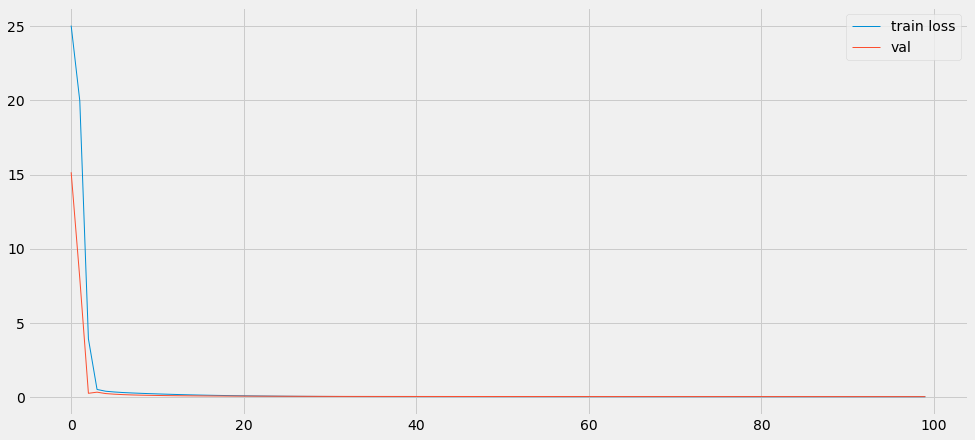

In [145]:
plt.plot(history['train_loss'], label="train loss")
plt.plot(history['val_loss'], label="val")
plt.legend()

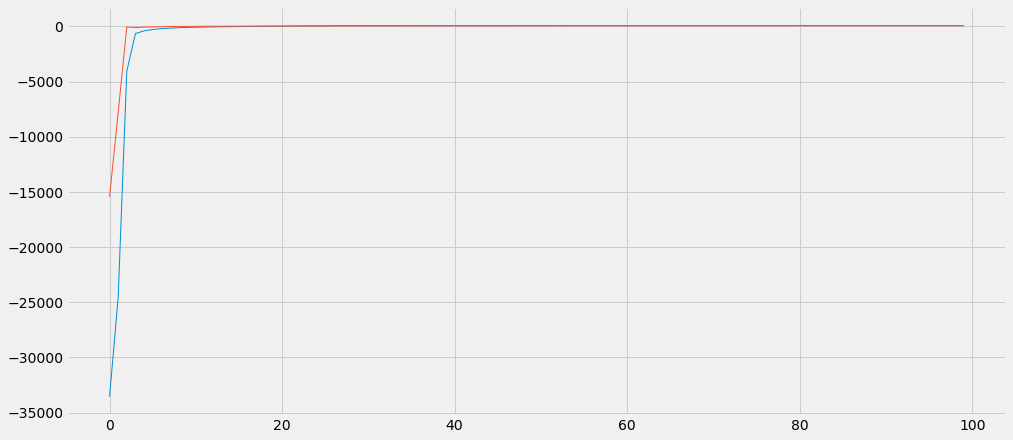

In [146]:
plt.plot(np.array(history['train_score'])*100)
plt.plot(np.array(history['val_score'])*100)

In [147]:
def predict(data_loader):
    model.eval()
    preds = np.array([])
    for data in data_loader:
        X = data['X'].to(DEVICE)
        pred = model(X)
        pred = pred.detach().cpu().numpy()
        
        preds = np.append(preds, pred)
    
    return preds

In [148]:
train_preds = predict(train_loader)
val_preds = predict(val_loader)
test_preds = predict(test_loader)

In [380]:
def plot_res(y_true, y_pred, true_label, pred_label="Predictions"):
    plt.figure(figsize=(16,5))
    plt.plot(y_true, label=true_label)
    plt.plot(y_pred, label=pred_label)
    plt.xlabel('Days')
    plt.ylabel('Prices($)')
    plt.legend()
    plt.show()

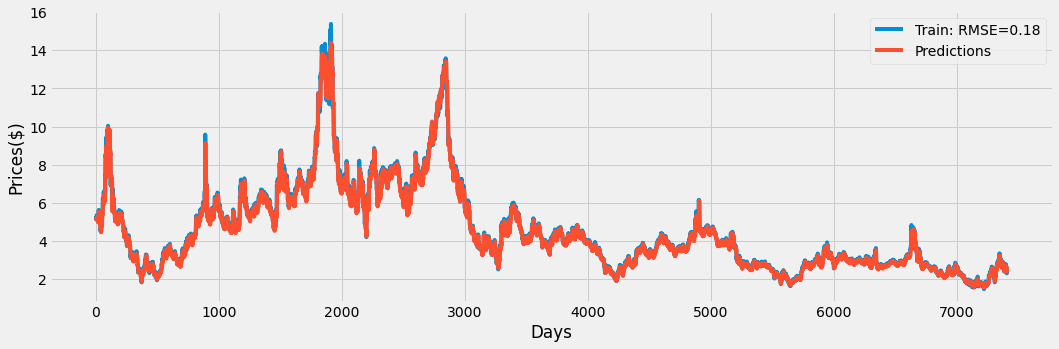

In [383]:
plot_res(y_train, train_preds, "Train: RMSE={}".format(round(np.sqrt(mse) ,2)))

In [151]:
r2_score(y_train, train_preds)

0.9941089372770925

In [382]:
mse= mean_squared_error(y_train, train_preds)
mse, np.sqrt(mse)

(0.03071295826625778, 0.17525112914403085)

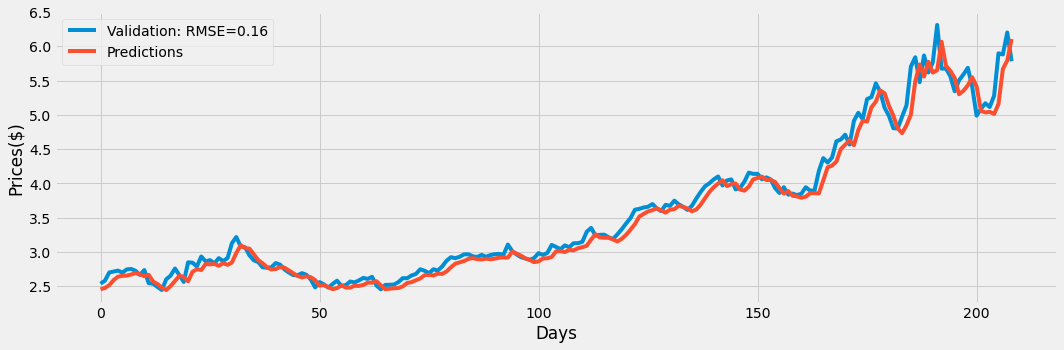

In [387]:
plot_res(y_val, val_preds, "Validation: RMSE={}".format(round(np.sqrt(mse) ,2)))

In [154]:
r2_score(y_val, val_preds)

0.9756664598619958

In [386]:
mse= mean_squared_error(y_val, val_preds)
mse, np.sqrt(mse)

(0.025260300680692013, 0.15893489447157919)

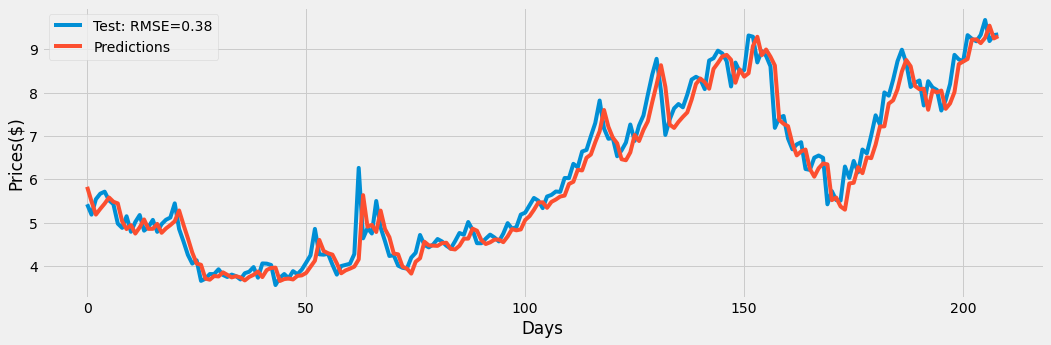

In [389]:
plot_res(y_test, test_preds, "Test: RMSE={}".format(round(np.sqrt(mse) ,2)))

In [157]:
r2_score(y_test, test_preds)

0.9533739632893972

In [388]:
mse= mean_squared_error(y_test, test_preds)
mse, np.sqrt(mse)

(0.147483527198983, 0.3840358410343792)

In [159]:
model.to("cuda")

Model(
  (lstm): LSTM(21, 273, num_layers=3, batch_first=True)
  (linear): Linear(in_features=273, out_features=1, bias=True)
)

In [249]:
val_preds_df = pd.DataFrame(val_preds, columns=['Preds'],index=val_test_dates[:len(val_preds)])

In [250]:
test_preds_df = pd.DataFrame(test_preds, columns=['Preds'],index=val_test_dates[len(val_preds)-1:])

In [224]:
def predict(model, forecast_len):
    model.eval()
    
    X = scaler.inverse_transform(X_test[-1][:].reshape(1,-1))[0,1:]
    X = np.append(X, y[-1]).reshape(1,-1)
    X = scaler.transform(X)
    
    preds = []
    for i in range(forecast_len):
        X = torch.tensor(X, dtype=torch.float32)
        X = torch.reshape(X,(1,1,-1))
        
        pred = model(X.to(DEVICE))
        
        X = X.cpu().data.numpy()
        X = scaler.inverse_transform(X[-1][:].reshape(1,-1))[0,1:]
        X = np.append(X.flatten(), pred.cpu().data.numpy()[0]).reshape(1,-1)
        X = scaler.transform(X)
        
        preds.append(pred.detach().cpu().data.numpy()[0])
        
    return preds

In [238]:
preds = predict(model,1225)

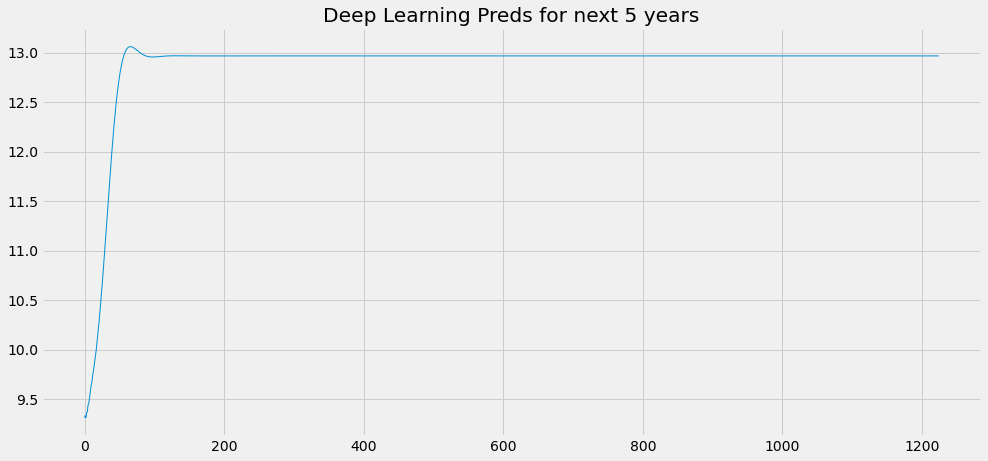

In [239]:
plt.title("Deep Learning Preds for next 5 years")
plt.plot(preds)
plt.show()

### DataFrame for 5 years ahead predictions

In [369]:
pd.Series(train_preds, index=train_df['Date'][timestamps:]).to_csv("DL train preds.csv")

In [289]:
start = datetime(2022, 8, 26)
end = datetime(2026,1,1)

In [241]:
dates = pd.date_range(start,end)

In [242]:
dates = np.array(dates)

In [243]:
pred_df = pd.DataFrame(preds, columns=['Predictions'], index=dates)

In [244]:
pred_df.to_csv("DL 5 preds1.csv")

In [245]:
pred_df

,Predictions
2022-08-26,9.312222
2022-08-27,9.333599
2022-08-28,9.312801
2022-08-29,9.363453
2022-08-30,9.370561
...,...
2025-12-28,12.968980
2025-12-29,12.968980
2025-12-30,12.968980
2025-12-31,12.968980


In [246]:
def calc_conf_inv(pred, level):
    '''function to calculate confidence intervals for given significance level'''
    alpha_dct = {90:1.64, 95:1.96, 96:2.05, 97:2.17, 98:2.33, 99:2.58}
    alpha = alpha_dct[level]
    
    stdev = np.std(pred)
    uncertainity = alpha*stdev
    
    lower_bound = pred - uncertainity
    upper_bound = pred + uncertainity
    
    results = pd.DataFrame({'Predictions':pred, 'Lower Bound':lower_bound, 'Upper Bound':upper_bound})
    
    return results

In [252]:
val_res = calc_conf_inv(val_preds_df['Preds'], 95)

In [253]:
test_res = calc_conf_inv(test_preds_df['Preds'], 95)

In [247]:
res = calc_conf_inv(pred_df['Predictions'], 95)

In [248]:
res

,Predictions,Lower Bound,Upper Bound
2022-08-26,9.312222,8.354412,10.270031
2022-08-27,9.333599,8.375790,10.291409
2022-08-28,9.312801,8.354992,10.270611
2022-08-29,9.363453,8.405643,10.321262
2022-08-30,9.370561,8.412751,10.328370
...,...,...,...
2025-12-28,12.968980,12.011170,13.926789
2025-12-29,12.968980,12.011170,13.926789
2025-12-30,12.968980,12.011170,13.926789
2025-12-31,12.968980,12.011170,13.926789


In [87]:
res.to_csv("preds/DL full conf.csv")

In [254]:
val_res.to_csv("preds/DL val conf.csv")
test_res.to_csv("preds/DL test conf.csv")

In [338]:
df_full = pd.concat([val_res, test_res, res], axis=0).reset_index()

In [339]:
df_full.rename(columns={"index":'Date'}, inplace=True)

In [340]:
df_full['Date'] = pd.to_datetime(df_full['Date'])

In [341]:
df_full

,Date,Predictions,Lower Bound,Upper Bound
0,2021-01-04,2.457146,0.501379,4.412913
1,2021-01-05,2.476013,0.520246,4.431780
2,2021-01-06,2.516657,0.560890,4.472424
3,2021-01-07,2.590992,0.635225,4.546759
4,2021-01-08,2.640812,0.685045,4.596579
...,...,...,...,...
1638,2025-12-28,12.968980,12.011170,13.926789
1639,2025-12-29,12.968980,12.011170,13.926789
1640,2025-12-30,12.968980,12.011170,13.926789
1641,2025-12-31,12.968980,12.011170,13.926789


In [342]:
all_dates = pd.Series(pd.date_range(start=datetime(2021,1,1), end=datetime(2026,1,1)), name='Date')

In [343]:
all_dates

0      2021-01-01
1      2021-01-02
2      2021-01-03
3      2021-01-04
4      2021-01-05
          ...    
1822   2025-12-28
1823   2025-12-29
1824   2025-12-30
1825   2025-12-31
1826   2026-01-01
Name: Date, Length: 1827, dtype: datetime64[ns]

In [344]:
len(all_dates)

1827

In [345]:
df_full = pd.merge(all_dates, df_full, how='left', on='Date')

In [346]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1828 entries, 0 to 1827
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1828 non-null   datetime64[ns]
 1   Predictions  1643 non-null   float64       
 2   Lower Bound  1643 non-null   float64       
 3   Upper Bound  1643 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 71.4 KB


In [347]:
df_full.ffill(inplace=True)

In [348]:
df_full.bfill(inplace=True)

In [349]:
df_full = df_full.drop_duplicates(subset='Date', keep="first")

In [350]:
df_full.to_csv("preds/DL(LSTM) complete preds.csv", index=False)

In [285]:
all_dates = pd.Series(pd.date_range(start=datetime(2021,1,1), end=datetime(2026,1,2)), name='Date')

In [286]:
df_full.index = all_dates

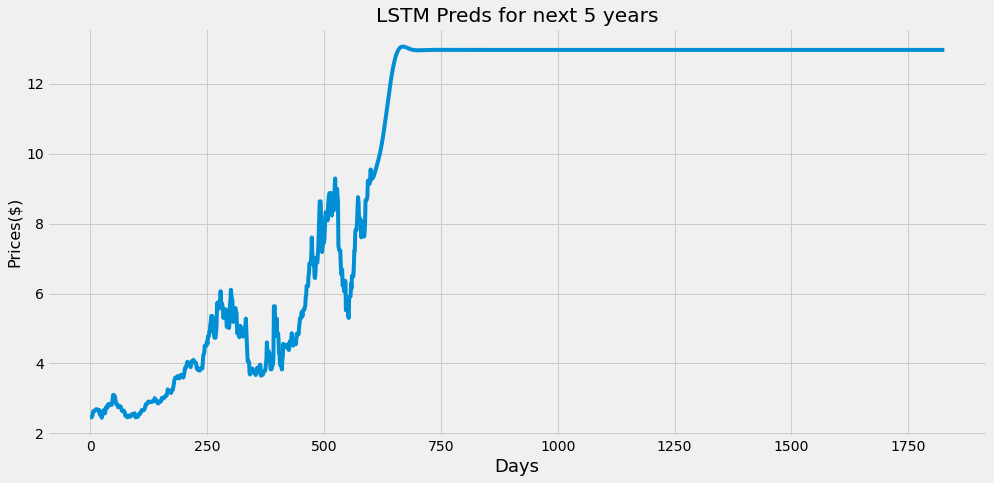

In [391]:
plt.title("LSTM Preds for next 5 years")
plt.plot(df_full["Predictions"])
plt.xlabel('Days', fontsize=18)
plt.ylabel('Prices($)', fontsize=16)
plt.show()